# Explanation of extra zero cost cycles in GCS Solution

I noticed that the gcs solution returned flows where there was an extra cycle (outside of the solution from source to target) and was wondering if this is expected behavior. It is expected behavior. This is because as configured, since those specific sets overlap, that cycle is zero cost, and it doesn't violate any constraints, so it's perfectly valid and fine.

If you did want to not have this behavior, you could
1. Make the edge cost max(standard edge cost, small epsilon), that way there will be no zero cost edges, but this is still convex.
2. Require the sets be disjoint

But we aren't bothered by this, I just need to adjust my path checking code to not freak out.

In [1]:
from large_gcs.graph.cost_factory import (
    create_l2norm_edge_cost,
    create_l2norm_squared_edge_cost,
)
from large_gcs.example_graphs.utils.spp_shape_gcs_utils import (
    generate_spp_shape_gcs,
    load_spp_shape_gcs,
    SppShapeGcsGeneratorParams,
)
from large_gcs.algorithms.gcs_dijkstra import GcsDijkstra
from large_gcs.algorithms.search_algorithm import AlgVisParams
import matplotlib.pyplot as plt
import os
import numpy as np

## Configure Params

In [2]:
# 100 Vertex example
workspace_radius = 25
params = SppShapeGcsGeneratorParams(
    n_sets=100,
    workspace=(
        [-workspace_radius, workspace_radius],
        [-workspace_radius, workspace_radius],
    ),
    source=(0, 0),
    target=(workspace_radius * 0.7, workspace_radius * 0.7),
    set_scale=1.2,
    k_nearest_edges=(3, 8),
    k_nearest_pool=10,
    random_seed=490052,
    should_save=True,
)

In [3]:
file_name = f"spp_{params.dim}d_v{params.n_sets}_shape_gcs.npy"
graph_file = os.path.join(
    os.environ["PROJECT_ROOT"], "large_gcs", "example_graphs", file_name
)
params.save_path = graph_file

## Generate the graph

In [ ]:
G = generate_spp_shape_gcs(params)

# draw convex sets and edges
plt.figure(figsize=(20, 20))
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
plt.grid()
plt.xlim(params.workspace[0] * 1.2)
plt.ylim(params.workspace[1] * 1.2)
plt.show()

## Standard GCS solve on entire graph

Adding points as vertices to the graph...


100%|██████████| 2/2 [00:00<00:00, 6864.65it/s]


Adding ellipsoids as vertices to the graph...


100%|██████████| 54/54 [00:00<00:00, 15742.85it/s]


Adding polyhedra as vertices to the graph...


100%|██████████| 46/46 [00:00<00:00, 67.68it/s]


Adding edges to the graph...


100%|██████████| 101/101 [00:00<00:00, 2331.67it/s]


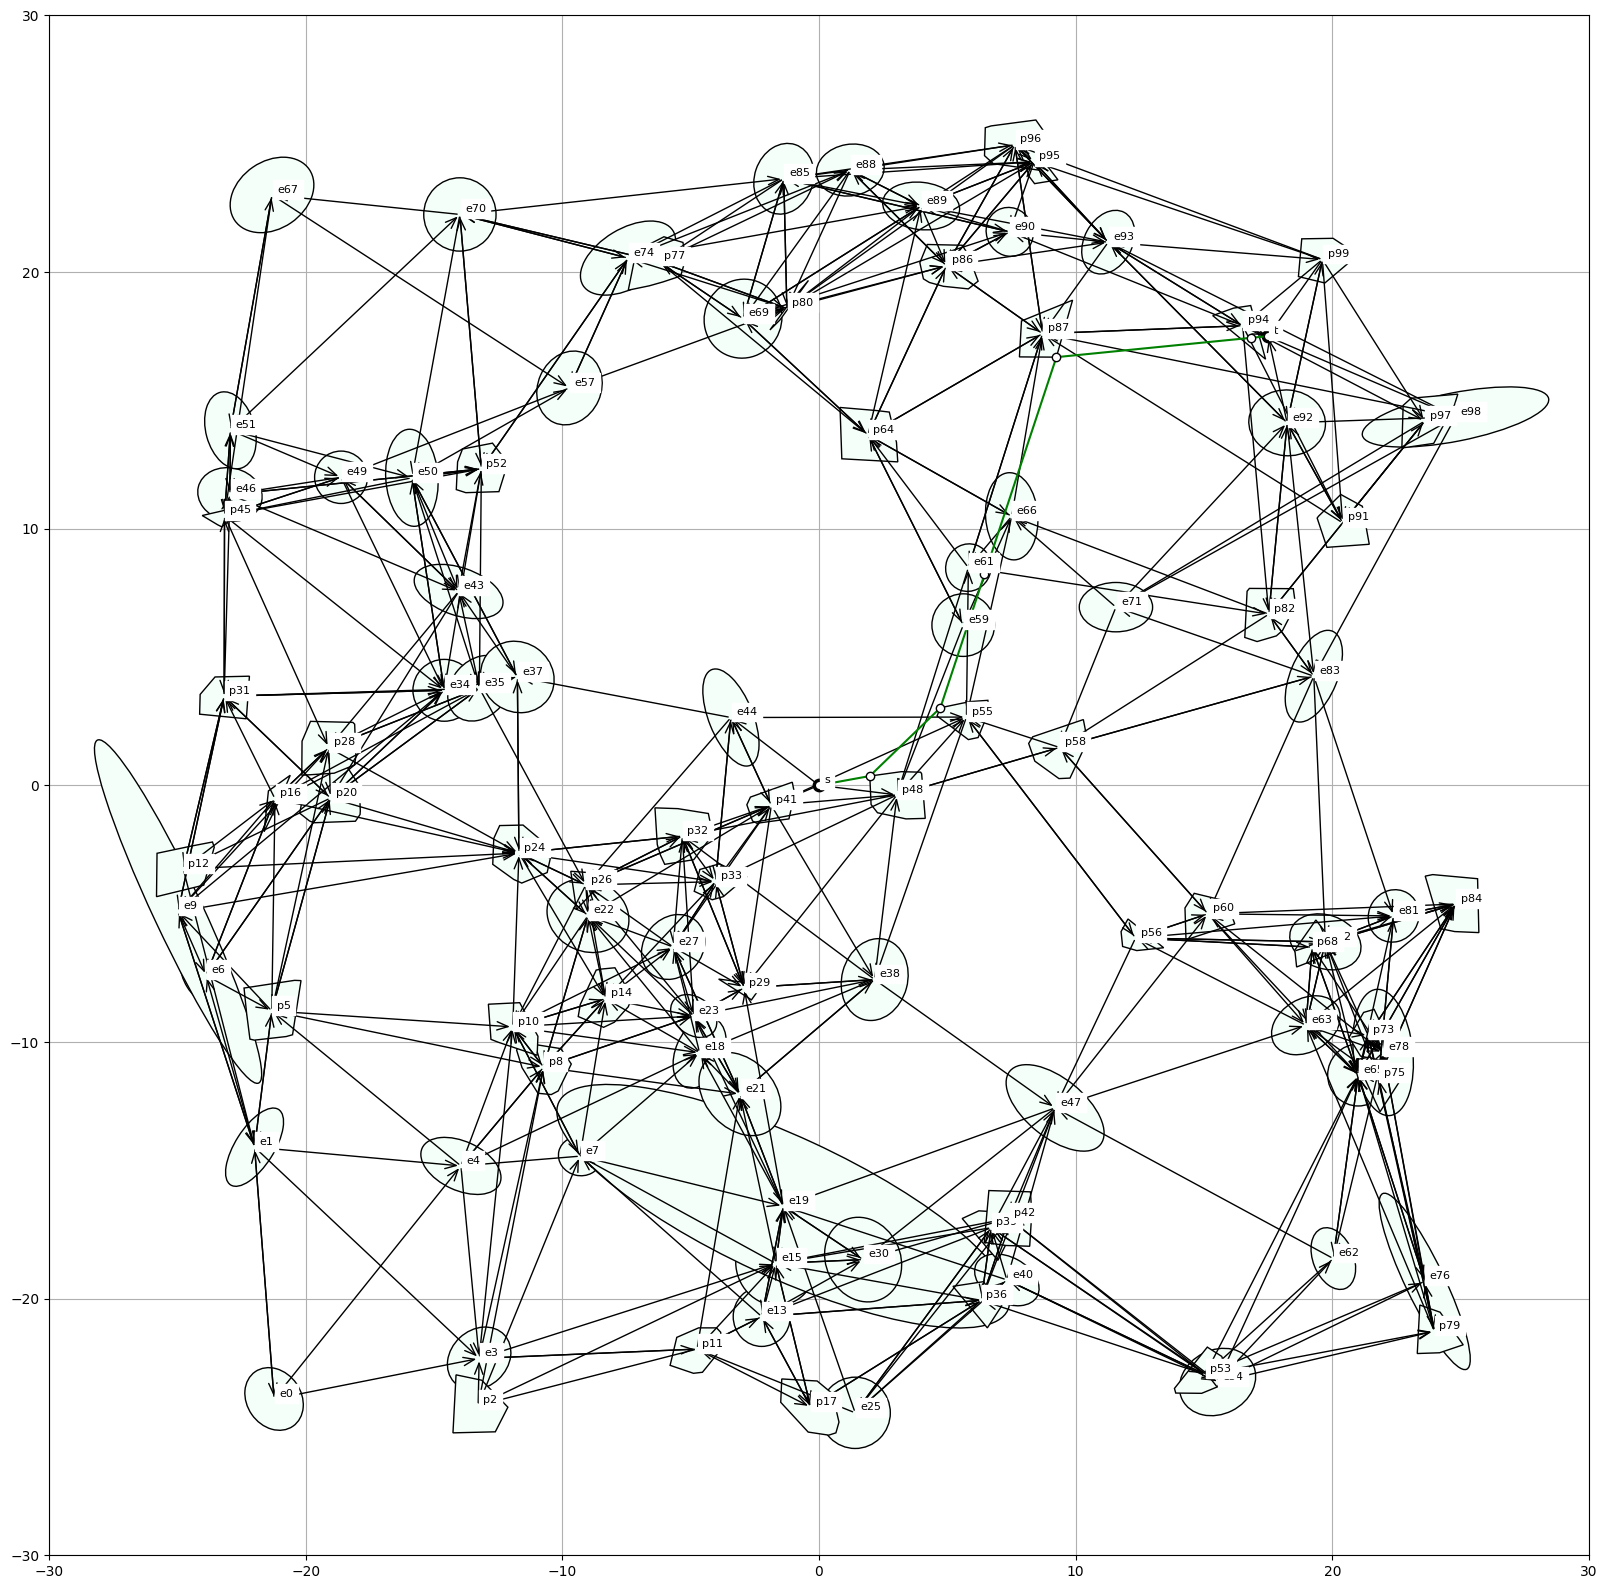

In [4]:
G = load_spp_shape_gcs(graph_file, create_l2norm_edge_cost)
sol = G.solve_shortest_path()

# draw convex sets and edges
plt.figure(figsize=(20, 20))
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
G.plot_path(sol.path)
plt.grid()
plt.xlim(np.array(params.workspace[0]) * 1.2)
plt.ylim(np.array(params.workspace[1]) * 1.2)

plt.show()

## Debugging "Path length does not match number of edges"

In [5]:
for edge, flow in zip(G.edge_keys, sol.flows):
    if flow > 0.99:
        print(f"{edge}: {flow}")

('s', 'p48'): 1.0
('p48', 'p55'): 1.0
('p55', 'e61'): 1.0
('e61', 'p87'): 1.0
('e65', 'p75'): 1.0
('p75', 'e78'): 1.0
('e78', 'e65'): 1.0
('p87', 'p94'): 1.0
('p94', 't'): 1.0


In [6]:
vs = ["e65", "p75", "e78"]
for v in vs:
    print(f"Incoming edges from {v}")
    print([e.u for e in G.incoming_edges(v)])
    print(f"Outgoing edges from {v}")
    print([e.v for e in G.outgoing_edges(v)])

Incoming edges from e65
['p53', 'e54', 'p60', 'e62', 'e63', 'p68', 'e72', 'p73', 'p75', 'e76', 'e78', 'p79', 'e81', 'p84']
Outgoing edges from e65
['p68', 'p75', 'e62', 'e76', 'p84', 'p73', 'e63']
Incoming edges from p75
['e65', 'p79', 'e81', 'p84']
Outgoing edges from p75
['e63', 'e72', 'e65', 'p84', 'e78', 'p73', 'e81']
Incoming edges from e78
['e62', 'e63', 'p68', 'p73', 'p75', 'e76', 'p79']
Outgoing edges from e78
['p60', 'p73', 'e65']
